# Thinc

The central problem for a neural network implementation is this: during the forward pass, you compute results that will later be useful during the backward pass. How do you keep track of this arbitrary state, while making sure that layers can be cleanly composed?

Most libraries solve this problem by having you declare the forward computations, which are then compiled into a graph somewhere behind the scenes. Thinc doesn't have a "computational graph". Instead, we just use the stack, because we put the state from the forward pass into callbacks.

https://github.com/explosion/thinc

All nodes in the network have a simple signature:

``` python
f(inputs) -> {outputs, f(d_outputs)->d_inputs}
```


In [1]:
import numpy as np
import logging
logging.basicConfig(filename='debug.log',level=logging.DEBUG)

## Activations

In [2]:
def relu(inputs):
    mask = inputs > 0
    def backprop_relu(d_outputs, optimizer):
        return d_outputs * mask
    return inputs * mask, backprop_relu

## Layers

In [3]:
def create_linear_layer(n_out, n_in):
    W = np.random.randn(n_out, n_in)
    b = np.zeros((n_out, 1))

    def forward(X):
        Y = W @ X + b
        logging.debug("[->]: %s, %s, %s" % (Y.shape, W.shape, b.shape))
        def backward(dY, optimizer):
            logging.debug("[<-]: %d, %d" % dY.shape)
            dX = W.T @ dY
            dW = np.einsum('ik,jk->ij', dY, X)
            db = dY.sum(axis=1, keepdims=True)
           
            optimizer(W, dW)
            optimizer(b, db)

            return dX
        return Y, backward
    return forward

## Utils

In [4]:
def chain(*layers):
    '''
    Chain together layers
    '''
    def forward(X):
        backprops = []
        Y = X
        for layer in layers:
            Y, backprop = layer(Y)
            backprops.append(backprop)
        
        def backward(dY, optimizer):
            for backprop in reversed(backprops):
                dY = backprop(dY, optimizer)
            return dY
        
        return Y, backward
    
    return forward

## Optimizer

In [5]:
def sgd(theta, dtheta, alpha = 0.001):
    theta -= alpha * dtheta

## Cost

In [6]:
def create_mse_layer(y):
    def forward(X):
        cost = np.average((X - y)**2)
        
        def backward(dY, optimizer):
            dX = -2 * (y - X)
            return dX
        
        return cost, backward
    
    return forward

## Train

In [7]:
def train(X, y, model, optimizer, epochs = 10):    
    for i in range(epochs):
        cost, backpropagate = model(X)
        backpropagate(1, sgd)

        yield i, cost

## Sample data

In [8]:
def data(N, features_num, m=3):
    X = np.random.randn(features_num, N)
    W1 = np.random.randn(m, features_num)
    W2 = np.random.randn(1, m)

    y = W1 @ X
    y = W2 @ (y *(y > 0))
    
    return  X, y

## Model example

In [9]:
EPOCHS = 10
NUM_EXAMPLES = 100
NUM_FEATURES = 5

X, y = data(NUM_EXAMPLES, NUM_FEATURES)

In [10]:
affine_1 = create_linear_layer(3, 5)
affine_2 = create_linear_layer(1, 3)
mse = create_mse_layer(y)

mlp = chain(affine_1, relu, affine_2, mse)

In [11]:
costs = [(i, c) for (i, c) in train(
    X, y,
    epochs = EPOCHS, 
    model = mlp,
    optimizer = sgd
)] 


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
xs, ys = zip(*costs)

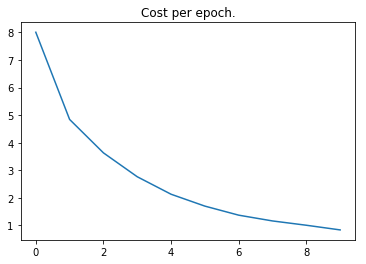

In [14]:
plt.title("Cost per epoch.")
plt.plot(xs, ys);